# Readability metrics

In [1]:
import os
import pandas as pd
import textstat
import numpy as np
from scipy import stats
from bs4 import BeautifulSoup
import chardet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("./../..")
print(os.getcwd())

SAVE_FOLDER = "data/output/fatigue_metric_data"


/home/gabri/Desktop/ADA/ada-2024-project-theadacuates


## Define Metrics that will be used

Another metric that can quantify the cognitive load of the game, as well as the possibility of prematurely abandoning it due to high difficulty, is readability metrics. In general, these metrics measure the ease with which a reader can understand a text. Factors such as sentence length, word complexity, and the use of jargon all contribute to these measurements. Readability metrics, such as the Flesch-Kincaid readability test or the Gunning Fog index, can be deemed good proxies for cognitive load because they reflect how accessible the game’s content is to players.

Let's define some of them:

### 1. **Flesch-Kincaid Grade Level:**
   - **What it measures:** This metric estimates the U.S. school grade level someone needs to understand a given text. It's based on sentence length (average words per sentence) and word complexity (average syllables per word).
   - **How it works:** The formula produces a score corresponding to a U.S. grade level. For example, if the score is **8**, it means the text is understandable by someone in the **8th grade**.
   - **Use:** Commonly used in educational settings and to gauge the complexity of texts like books, articles, and manuals.

   **Formula:**
$$
   0.39 \times \left(\frac{\text{total words}}{\text{total sentences}}\right) + 11.8 \times \left(\frac{\text{total syllables}}{\text{total words}}\right) - 15.59
$$

### 2. **Gunning Fog Index:**
   - **What it measures:** This metric estimates the number of years of formal education required to understand the text on a first reading. It's based on sentence length and the percentage of complex words (words with three or more syllables).
   - **How it works:** A higher score means the text is more difficult to read. A score of **12** would indicate a **12th-grade** reading level (high school senior), and a score of **17** would indicate the level expected for a college graduate.
   - **Use:** Often used in business and technical writing to ensure clarity and accessibility for readers.

   **Formula:**
$$
   0.4 \times \left( \left( \frac{\text{total words}}{\text{total sentences}} \right) + \frac{\text{complex words}}{\text{total words}} \times 100 \right)
$$

### 3. **Automated Readability Index (ARI):**
   - **What it measures:** This metric calculates the approximate U.S. grade level needed to comprehend a text. It uses **sentence length** (words per sentence) and **word length** (characters per word) to determine complexity.
   - **How it works:** The ARI produces a score similar to grade levels. For instance, a score of **7** means the text can be understood by a 7th-grade student.
   - **Use:** Useful for evaluating materials such as online content, educational resources, and manuals.

   **Formula:**
$$
   4.71 \times \left(\frac{\text{total characters}}{\text{total words}}\right) + 0.5 \times \left(\frac{\text{total words}}{\text{total sentences}}\right) - 21.43
$$

5. Readability Consensus Index
### 5. **Readability Consensus Index**
What it measures: This combines several readability formulas (like Flesch-Kincaid, Gunning Fog, ARI) into a single score that estimates the overall readability of the text.
How to calculate: Average the results of different readability formulas.


In [3]:
df_names = pd.read_csv("data/output/processed_data/articles_processed.csv")
df_names.head(2)

,article_name,article_name_encoded,article_id
0,Áedán mac Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
1,Åland,%C3%85land,1


# Calculate Metrics

### From longer articles version

In [4]:
def long_calculate_fatigue_metrics(article_name, folder="data/raw/wpcd/wp"):
    article_path = article_name + ".htm"
    found_file = None

    # Search for the file in the specified folder
    for root, dirs, files in os.walk(folder):
        if article_path in files:
            found_file = os.path.join(root, article_path)
            print(f"File found: {found_file}")
            break

    # If file is not found, print a message and return
    if not found_file:
        print(f"File NOT found: {article_path}")
        return
    
    # Detect encoding
    with open(found_file, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        encoding = result['encoding']
        print(f"Detected encoding: {encoding}")

    # Read the .htm file with the detected encoding
    with open(found_file, 'r', encoding=encoding) as file:
        content = file.read()

    # Parse the file content with BeautifulSoup
    soup = BeautifulSoup(content, 'lxml')

    # Extract all paragraphs and join them into a single string
    text = " ".join([p.get_text() for p in soup.find_all('p')])

    #print(text)

    # Calculate readability scores
    flesch_kincaid = textstat.flesch_kincaid_grade(text)
    gunning_fog = textstat.gunning_fog(text)
    ari = textstat.automated_readability_index(text)
    smog = textstat.smog_index(text)
    coleman_liau = textstat.coleman_liau_index(text)

    # Calculate Readability Consensus Index by averaging the scores
    readability_consensus = (flesch_kincaid + gunning_fog + ari + smog + coleman_liau) / 5

    #print(f"Processing {article_name}...")

    # Return the results as a dictionary
    return {
        'article_name_encoded': article_name,
        'Flesch-Kincaid': flesch_kincaid,
        'Gunning Fog': gunning_fog,
        'ARI': ari,
        'SMOG': smog,
        'Coleman-Liau': coleman_liau,
        'Readability Consensus': readability_consensus
    }


In [5]:
csv_path = os.path.join(SAVE_FOLDER, "articles_fatigues_long.csv")

if not os.path.exists(csv_path):
    # Apply the function to the DataFrame
    metrics_df = df_names["article_name_encoded"].apply(lambda x: long_calculate_fatigue_metrics(article_name = x, folder="data/raw/wpcd/wp"))

    # Convert the results to a DataFrame for easier analysis
    metrics_df = pd.DataFrame(list(metrics_df))

    # Add to origna df
    df_fatigue = pd.merge(df_names, metrics_df, on="article_name_encoded")

    # Display the results
    #display(metrics_df)
    display(df_fatigue) 

    df_fatigue.to_csv(csv_path, index = False)

df_fatigue = pd.read_csv(csv_path)

### From shorter articles version --> Not used


In [ ]:
# def short_calculate_fatigue_metrics(folder, article_name):
#     article_path = article_name + ".txt"
#     try:
#         # Step 1: Read the article content
#         with open(os.path.join(folder, article_path), 'r', encoding='utf-8') as file:
#             text = file.read()
        
#         # Step 2: Calculate individual readability scores
#         flesch_kincaid = textstat.flesch_kincaid_grade(text)
#         gunning_fog = textstat.gunning_fog(text)
#         ari = textstat.automated_readability_index(text)
#         smog = textstat.smog_index(text)
#         coleman_liau = textstat.coleman_liau_index(text)

#         # Step 3: Calculate Readability Consensus Index by averaging the scores
#         readability_consensus = (flesch_kincaid + gunning_fog + ari + smog + coleman_liau) / 5

#         print(f"Processing {article_name}...")

#         # Return the results as a dictionary
#         return {
#             'article_name_encoded': article_name,
#             'Flesch-Kincaid': flesch_kincaid,
#             'Gunning Fog': gunning_fog,
#             'ARI': ari,
#             'SMOG': smog,
#             'Coleman-Liau': coleman_liau,
#             'Readability Consensus': readability_consensus
#         }
#     except Exception as e:
#         print(f"Error processing {article_name}: {e}")
#         return None  # Return None if there's an error

# if False: # Decided to not use this part
#     csv_path = os.path.join(SAVE_FOLDER, "articles_fatigues_short.csv")

#     if not os.path.exists(csv_path):
#         # Apply the function to the DataFrame
#         metrics_df = df_names["article_name_encoded"].apply(lambda x: short_calculate_fatigue_metrics("data/plaintext_articles", x))

#         # Convert the results to a DataFrame for easier analysis
#         metrics_df = pd.DataFrame(list(metrics_df))

#         # Add to origna df
#         df_fatigue = pd.merge(df_names, metrics_df, on="article_name_encoded")

#         # Display the results
#         #display(metrics_df)
#         display(df_fatigue)

#         df_fatigue.to_csv(csv_path, index = False)

#     df_fatigue = pd.read_csv(csv_path)

# Metrics for each Article

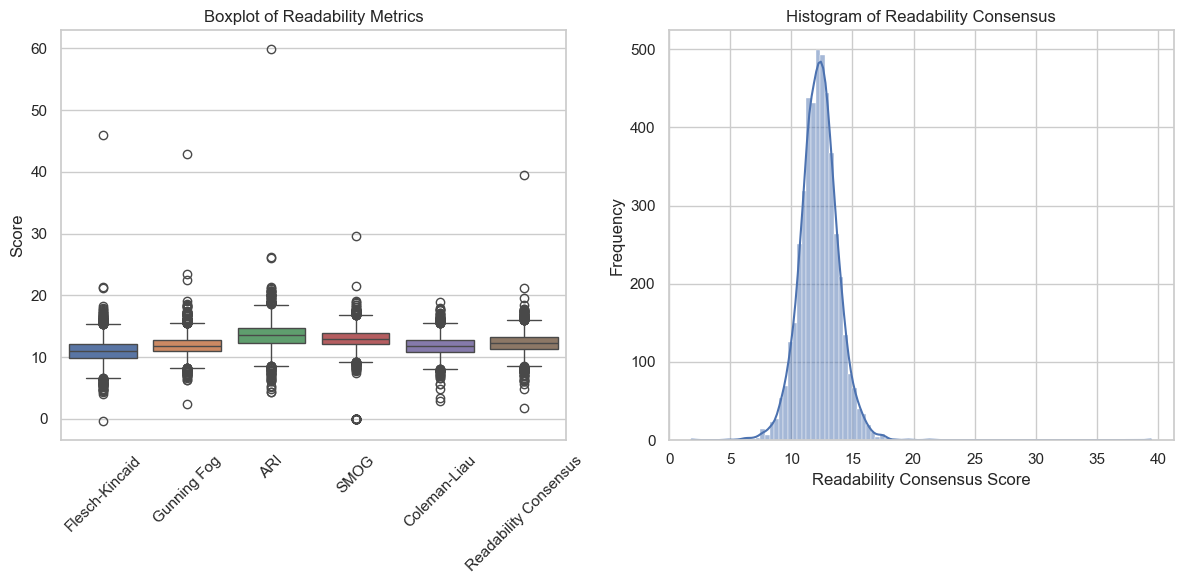

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Set the figure size
plt.figure(figsize=(12, 6))

# 1. Boxplot for readability metrics
plt.subplot(1, 2, 1)
sns.boxplot(data=df_fatigue[['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']])
plt.title('Boxplot of Readability Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)

# 2. Histogram for Readability Consensus
plt.subplot(1, 2, 2)
sns.histplot(df_fatigue['Readability Consensus'], bins=100, kde=True)
plt.title('Histogram of Readability Consensus')
plt.xlabel('Readability Consensus Score')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


In [6]:
# Calculate aggregate metrics
aggregate_metrics = df_fatigue[['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the aggregate metrics
display(aggregate_metrics)

,Flesch-Kincaid,Gunning Fog,ARI,SMOG,Coleman-Liau,Readability Consensus
mean,11.063054,11.911123,13.585404,12.974761,11.823812,12.271631
median,11.000000,11.830000,13.600000,13.000000,11.780000,12.266000
std,1.852231,1.577178,2.131589,1.814130,1.473235,1.593012
min,-0.400000,2.400000,4.300000,0.000000,2.830000,1.826000
max,45.900000,42.830000,59.900000,29.700000,18.880000,39.442000


# Metrics for each Path
Calculate the mean metrics for each path.

In [2]:
df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv")
display(df_paths.head(2))

/tmp/ipykernel_216330/1934264610.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv("data/output/processed_data/paths_processed.csv")


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic..."


In [10]:
# Create column with a list containign the fatigue metric of each article
# Inse each Path
import ast

#Function to extract fatigue metrics as lists
def id2fatigue(ids, metric):
  ids = ast.literal_eval(ids)
  return df_fatigue[metric].iloc[ids].tolist()

def meanList(list):
  #list = ast.literal_eval(list)
  return np.mean(list)

metrics = ['Flesch-Kincaid', 'Gunning Fog', 'ARI', 'SMOG', 'Coleman-Liau', 'Readability Consensus']
for metric in metrics:
  print(f"{metric}")
  df_paths[f'path_{metric}'] = df_paths['resolved_path_list_id'].apply(lambda x: id2fatigue(x, metric))
  df_paths[f'mean_path_{metric}'] = df_paths[f'path_{metric}'].apply(meanList)

df_paths.head(2)

Flesch-Kincaid
Gunning Fog
ARI
SMOG
Coleman-Liau
Readability Consensus


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,...,path_Gunning Fog,mean_path_Gunning Fog,path_ARI,mean_path_ARI,path_SMOG,mean_path_SMOG,path_Coleman-Liau,mean_path_Coleman-Liau,path_Readability Consensus,mean_path_Readability Consensus
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,...,"[10.3, 8.28, 10.15, 12.11, 11.29, 11.76, 12.75...",11.162222,"[9.3, 6.3, 8.4, 15.2, 13.5, 12.4, 15.9, 14.2, ...",12.088889,"[0.0, 0.0, 0.0, 13.5, 12.6, 12.4, 14.4, 13.1, ...",8.788889,"[7.02, 7.47, 8.7, 13.0, 12.3, 11.31, 13.93, 12...",10.945556,"[6.904000000000001, 5.609999999999999, 7.13000...",10.552667
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,...,"[10.3, 11.86, 12.75, 11.77, 12.05]",11.746000,"[9.3, 14.7, 15.9, 14.2, 13.6]",13.540000,"[0.0, 13.4, 14.4, 13.1, 13.1]",10.800000,"[7.02, 13.17, 13.93, 12.36, 12.42]",11.780000,"[6.904000000000001, 12.925999999999998, 13.856...",11.721200


In [11]:
df_paths.to_csv(os.path.join(SAVE_FOLDER, "path_processed_with_readability.csv"))

### Distribution of each metric split by finished paths

/tmp/ipykernel_216330/446415852.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv(os.path.join(SAVE_FOLDER, "path_processed_with_readability.csv"))


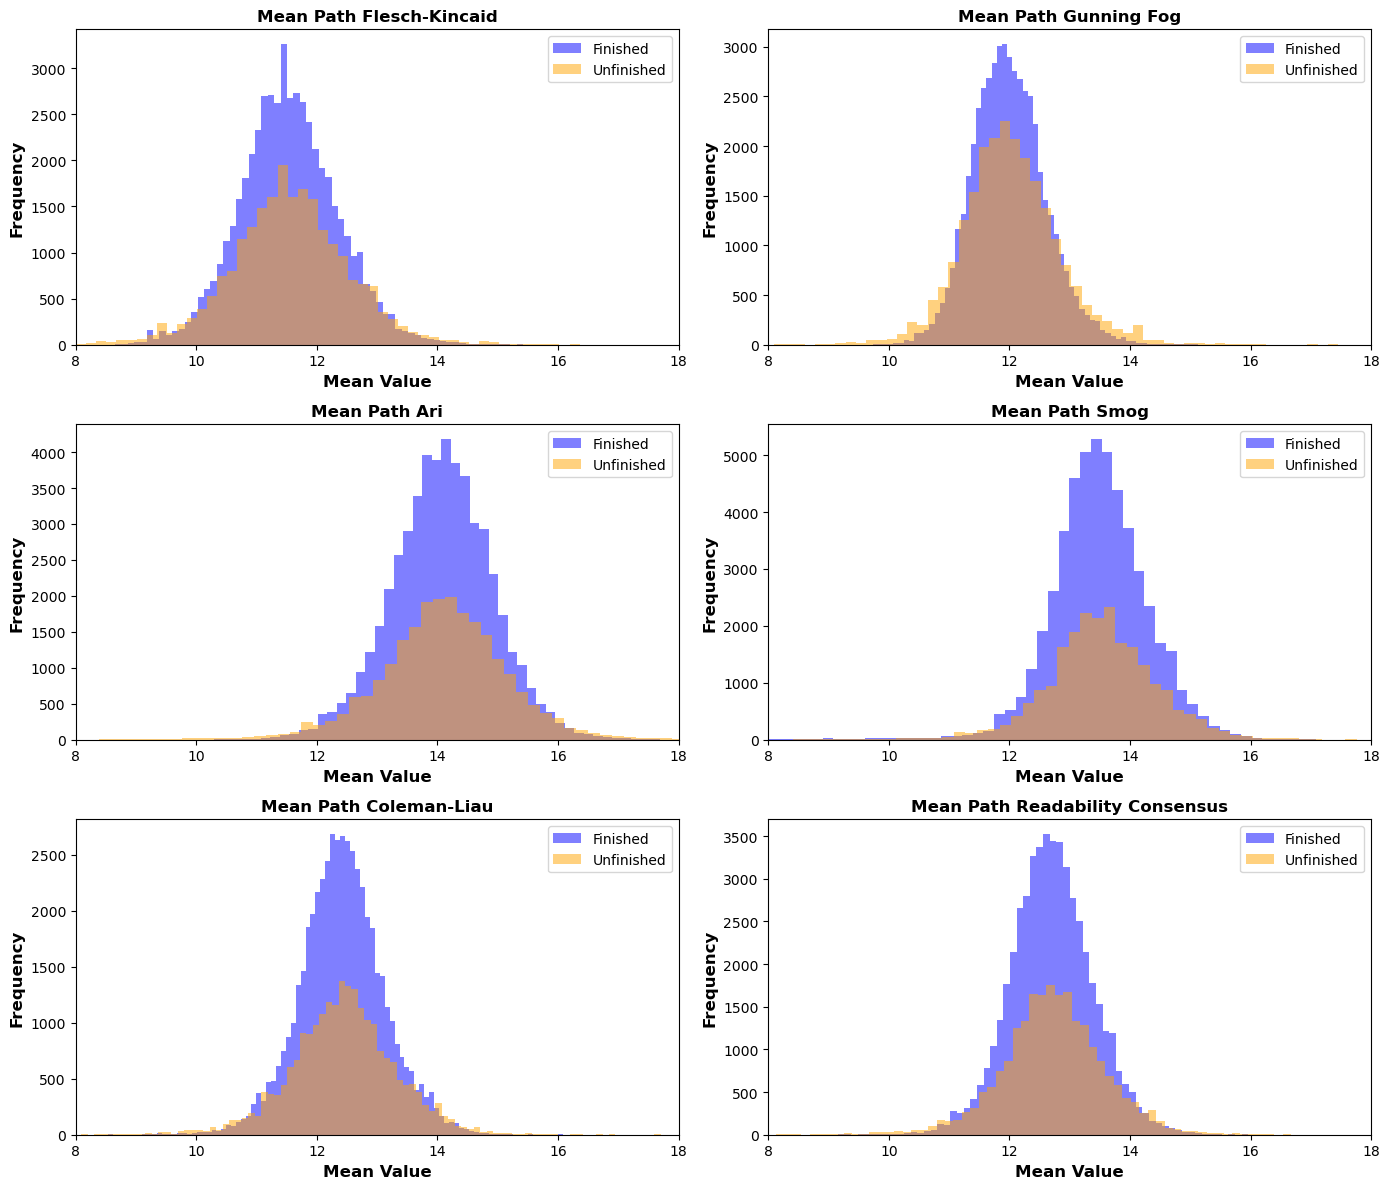

In [11]:
df_paths = pd.read_csv(os.path.join(SAVE_FOLDER, "path_processed_with_readability.csv"))


# Set up the figure and axes for the histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# List of metrics to plot
metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]

# Plot histograms for each metric, split by finished status
for i, metric in enumerate(metrics):
    # Plot for finished == True
    axes[i].hist(df_paths[df_paths['finished'] == True][metric], 
                  alpha=0.5, label='Finished', color='blue', bins=100)
    # Plot for finished == False
    axes[i].hist(df_paths[df_paths['finished'] == False][metric], 
                  alpha=0.5, label='Unfinished', color='orange', bins=100)
    
    # Set x-axis range to 8-18
    axes[i].set_xlim(8, 18)
    
    # Replace underscores and format the title
    formatted_title = metric.replace('_', ' ').replace('mean path', 'Mean Path').title()
    axes[i].set_title(formatted_title, fontweight='bold')  # Make the title bold
    
    # Labeling with bold fonts
    axes[i].set_xlabel('Mean Value', fontsize=12, fontweight='bold')  # Bold x-label
    axes[i].set_ylabel('Frequency', fontsize=12, fontweight='bold')  # Bold y-label
    axes[i].legend()
    
    # Save each plot as a separate image
    plt.figure()  # Create a new figure for saving individual plot
    plt.hist(df_paths[df_paths['finished'] == True][metric], 
             alpha=0.5, label='Finished', color='blue', bins=100)
    plt.hist(df_paths[df_paths['finished'] == False][metric], 
             alpha=0.5, label='Unfinished', color='orange', bins=100)
    plt.xlim(8, 18)
    plt.title(formatted_title, fontweight='bold')
    plt.xlabel('Mean Value', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./static/images/{metric.replace(" ", "_")}.png')  # Save with metric name as filename
    plt.close()  # Close the individual plot to avoid overlap

# Adjust layout for combined figure
plt.tight_layout()
plt.show()



### Correlation between metrics
As can be seen they are positive correlate, indeed they all measure the difficulty of the text. If the text is hard to comprehend it will be mirrored by all the metrics.

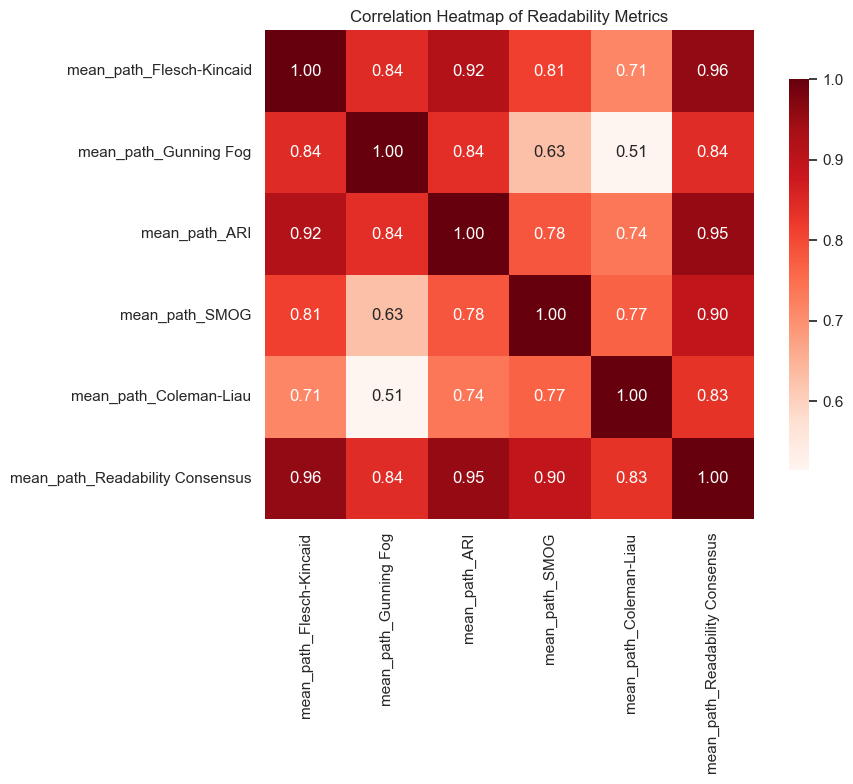

In [29]:
# Calculate correlation matrix
correlation_matrix = df_paths[metrics].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Reds', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Readability Metrics')
plt.tight_layout()
plt.show()


# Statistical test

In [30]:
# Calculate aggregate metrics
metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]
aggregate_metrics = df_paths.groupby("finished")[metrics].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the aggregate metrics
display(aggregate_metrics)

mean_path_Flesch-Kincaid                                   \
                             mean     median       std  min    max   
finished                                                             
False                   11.544714  11.533333  1.029254  4.5  21.20   
True                    11.531666  11.500000  0.813530  7.8  18.38   

         mean_path_Gunning Fog                                      ...  \
                          mean     median       std    min     max  ...   
finished                                                            ...   
False                12.025235  11.980000  0.840578  6.390  23.410  ...   
True                 11.996276  11.963636  0.607132  9.215  17.796  ...   

         mean_path_Coleman-Liau                                      \
                           mean     median       std   min      max   
finished                                                              
False                 12.429573  12.440000  0.905821  7.02  17.7000   
True                  12.419872  12.408889  0.701089  8.20  16.4075   

         mean_path_Readability Consensus                                      
                                    mean     median       std   min      max  
finished                                                                      
False                          12.715491  12.717000  0.894487  5.61  19.6140  
True                           12.700971  12.688222  0.692520  7.07  18.0468  

[2 rows x 30 columns]

In [31]:
# Store results
results = {}

metrics = [
    'mean_path_Flesch-Kincaid',
    'mean_path_Gunning Fog',
    'mean_path_ARI',
    'mean_path_SMOG',
    'mean_path_Coleman-Liau',
    'mean_path_Readability Consensus'
]

# Perform t-tests for each metric
for metric in metrics:
    finished_data = df_paths[df_paths['finished'] == True][metric]
    not_finished_data = df_paths[df_paths['finished'] == False][metric]
    
    t_stat, p_value = stats.ttest_ind(finished_data, not_finished_data, equal_var=False)  # Welch's t-test
    results[metric] = {'t_statistic': t_stat, 'p_value': p_value}

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T
results_df['significant'] = results_df['p_value'] < 0.05  # Determine significance

# Display results
print(results_df)

                                 t_statistic   p_value  significant
mean_path_Flesch-Kincaid           -1.695144  0.090057        False
mean_path_Gunning Fog              -4.691829  0.000003         True
mean_path_ARI                      -1.702027  0.088759        False
mean_path_SMOG                     -0.841386  0.400137        False
mean_path_Coleman-Liau             -1.438549  0.150287        False
mean_path_Readability Consensus    -2.180332  0.029239         True
